In [46]:
# Misc
RANDOM_STATE = 42

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import (classification_report,
                             confusion_matrix, accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score)

# Data splitting

In [48]:
!gdown --fuzzy https://drive.google.com/file/d/17qgFjTIUgxsiURgGjVC6WlEFn6Wl-OeJ/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=17qgFjTIUgxsiURgGjVC6WlEFn6Wl-OeJ
To: /content/cleaned_bmarket.csv
100% 2.65M/2.65M [00:00<00:00, 166MB/s]


In [49]:
df = pd.read_csv("./cleaned_bmarket.csv")

In [50]:
y = df['Subscription Status']
X = df.drop('Subscription Status', axis=1)
X = pd.get_dummies(X, drop_first=True) # PLEASE rememeber to research of label encoder

In [51]:
print(X.shape, y.shape)

(40787, 26) (40787,)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Misc

In [53]:
class ModelWrapper:
    def __init__(self, title, model, hyperparameters):
        self.title = title
        self.model = model(**hyperparameters)
        self.train_loss = []
        self.val_loss = []
        self.best_epoch = None

In [54]:
###################
# Hyperparameters #
###################

# Random Forest: {
MIN_ESTIMATORS = 50
MAX_ESTIMATORS = 150
STEPSIZE = 25

rf_params = {
    "n_jobs": -1,
    "min_samples_split": 2,
    "max_samples": X_train.shape[0], # Decrease for lower variance & higher bias
    "oob_score": True,
    "warm_start": True,
    "random_state": RANDOM_STATE
}
# }

# Ensemble models

### Random Forest

**Optimization Methods**


*   Hyperparamter tuning / Maybe grid search??
*   Adjusting decision threshold




In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
RfSqrt = ModelWrapper(
    title = "RandomForestClassifier, max_features=sqrt",
    model = RandomForestClassifier,
    hyperparameters = {**rf_params, "max_features": "sqrt"}
)

RfL2 = ModelWrapper(
    title = "RandomForestClassifier, max_features=log2",
    model = RandomForestClassifier,
    hyperparameters = {**rf_params, "max_features": "log2"}
)

RfBase = ModelWrapper(
    title = "RandomForestClassifier, max_features=None",
    model = RandomForestClassifier,
    hyperparameters = {**rf_params, "max_features": None}
)

In [57]:
rf_clfs = [
    RfSqrt,
    RfL2,
    RfBase
]

In [58]:
# IMPORTANT: Fix for parallel processing in kedro

for rf in rf_clfs:
    label = rf.title
    clf = rf.model
    train_loss = rf.train_loss
    val_loss = rf.val_loss

    min_oob_error = 999999999999999.99

    for e in range(MIN_ESTIMATORS, MAX_ESTIMATORS + 1, STEPSIZE):
        clf.set_params(n_estimators = e)
        clf.fit(X_train, y_train)

        bootstrap_accuracy = clf.score(X_train, y_train)
        bootstrap_error = 1 - bootstrap_accuracy
        train_loss.append((e, bootstrap_error))

        oob_error = 1 - clf.oob_score_
        val_loss.append((e, oob_error))

        if oob_error < min_oob_error:
            min_oob_error = oob_error
            rf.best_epoch = e

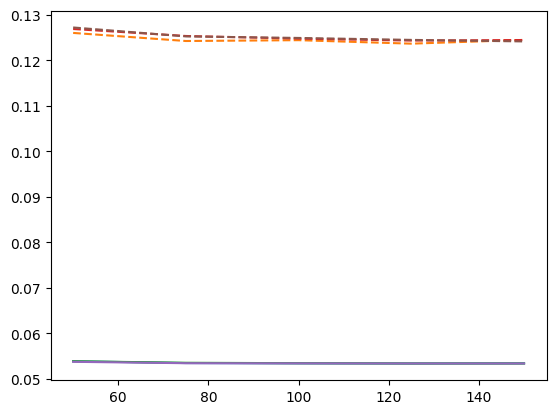

In [59]:
for rf in rf_clfs:
    xs_train, ys_train = zip(*rf.train_loss)
    plt.plot(xs_train, ys_train, label=f"{rf.title} (Train)", linestyle='-')

    xs_val, ys_val = zip(*rf.val_loss)
    plt.plot(xs_val, ys_val, label=f"{rf.title} (Val)", linestyle='--')

In [60]:
rf_sqrt_t = RfSqrt.model.set_params(n_estimators=RfSqrt.best_epoch)

In [61]:
RfSqrt.best_epoch

125

In [64]:
y_test_pred = rf_sqrt_t.predict(X_test)

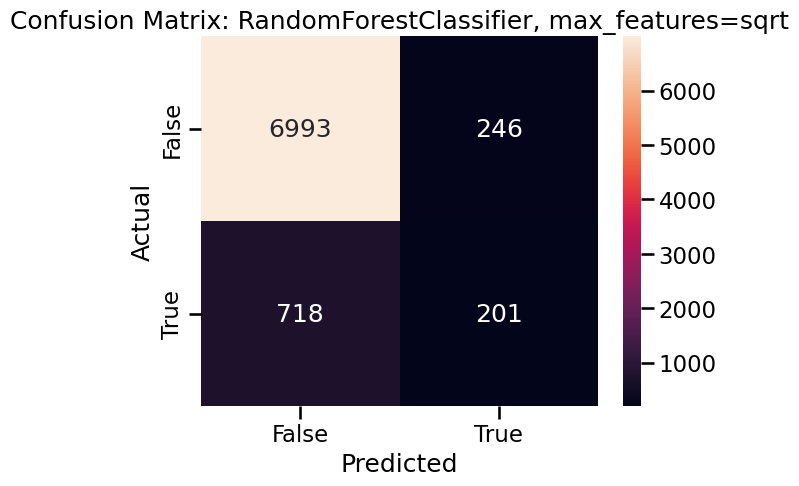

In [66]:
cm = confusion_matrix(y_test, y_test_pred)

sns.set_context('talk')
ax = sns.heatmap(cm, annot=True, fmt='d')
labels = ['False', 'True']

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.title(f'Confusion Matrix: {RfSqrt.title}')
plt.show()

In [67]:
def measure_error(y_true, y_pred, label):
    return pd.Series({
        'accuracy':accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)},
        name=label)

In [68]:
test_error = pd.concat([measure_error(y_test, y_test_pred, 'test')], axis=1)
test_error

,test
accuracy,0.881834
precision,0.449664
recall,0.218716
f1,0.294290
